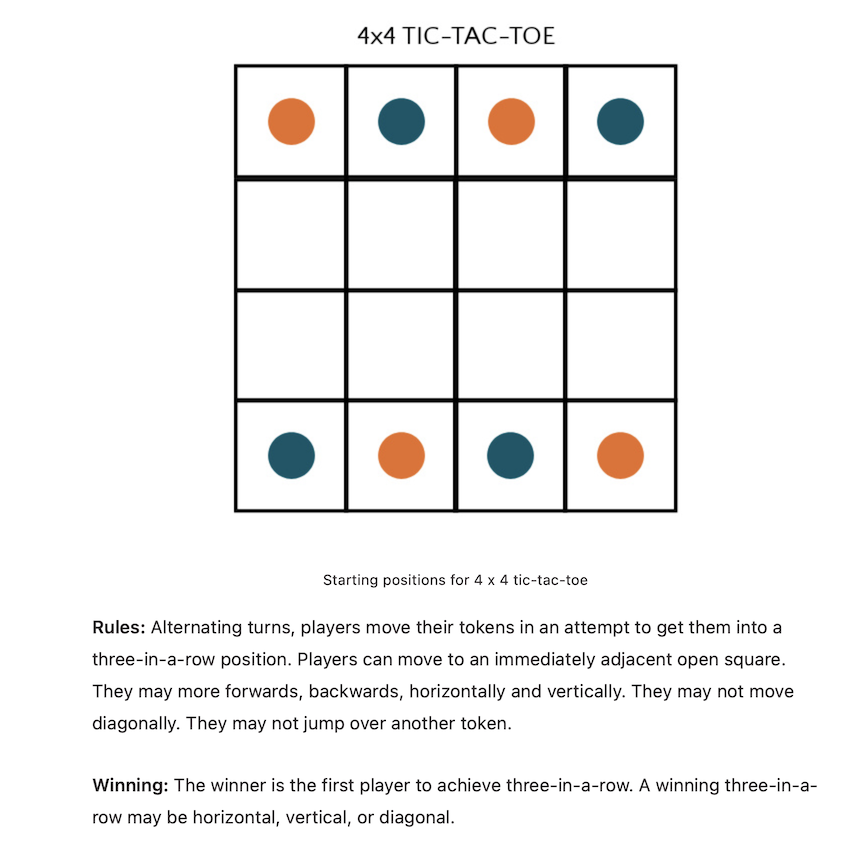

In [1]:
from Game import *
from Game.minimax import *
from tqdm import tqdm

Version:  0.2.42


## Game Functions

In [2]:
def initial_state():
    state=Board(4,4)

    #state[0]=state[2]=state[13]=state[15]=1

    for i in [0,2,13,15]:
        state[i]=1
        
    for i in [1,3,12,14]:
        state[i]=2

    return state

def show_state(state):
    print(state)

def valid_moves(state,player):

    
    moves=[]

    # single move is a start,end pair
    
    for i in range(16):
        # down
        if i not in [12,13,14,15] and state[i]==player and state[i+4]==0:
            moves.append( [i,i+4] )
        # up
        if i not in [0,1,2,3] and state[i]==player and state[i-4]==0:
            moves.append( [i,i-4] )
        # right
        if i not in [3,7,1,15] and state[i]==player and state[i+1]==0:
            moves.append( [i,i+1] )
        # left
        if i not in [0,4,8,12] and state[i]==player and state[i-1]==0:
            moves.append( [i,i-1] )


    return moves


def update_state(state,player,move):

    start,end=move

    new_state=state
    new_state[start]=0
    new_state[end]=player

    return new_state



def win_status(state,player):
    #  0  1  2  3 
    #  4  5  6  7 
    #  8  9 10 11 
    # 12 13 14 15 

    if player==1:
        other_player=2
    else:
        other_player=1

    # horizontal
    for i in [0,1,4,5,8,9,12,13]:
        if state[i]==state[i+1]==state[i+2]==player:
            return 'win'
    # vertical
    for i in [0,1,2,3,4,5,6,7]:
        if state[i]==state[i+4]==state[i+8]==player:
            return 'win'

    # diagonal-right
    for i in [0,1,4,5]:
        if state[i]==state[i+5]==state[i+10]==player:
            return 'win'
            
    # diagonal-left
    for i in [2,3,6,7]:
        if state[i]==state[i+3]==state[i+6]==player:
            return 'win'


    if not valid_moves(state,other_player):
        return 'stalemate'



## Agent Functions

In [3]:
def random_move(state,player):    
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    print("Player ", player)
    state.show_locations()
    print("Your valid moves are: ",valid_moves(state,player))
    valid_move=False
    while not valid_move:
        move=eval(input('What is your move? (e.g. [2,6]'))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move
human_agent=Agent(human_move)


In [4]:
def minimax_move(state,player):

    values,moves=minimax_values(state,player,maxdepth=5,display=False)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

In [5]:
def skittles_move(state,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action

    # make/adjust the table

    if state not in S:
        # add a row to the table for each move
        S[state]=Table()
        moves=valid_moves(state,player)
        for action in moves:
            S[state][action]=3  # number of skittles/beads for each move
    
    move=weighted_choice(S[state])

    if move is None:  # there are no skittles in this row
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0

        move=random_move(state,player)

    
    return move


In [6]:
def skittles_after(status,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action

    if status=='lose':
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0
                
    # does this double-count the learning if you lose on your own turn        
    

In [7]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move

def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [8]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.4  # learning rate
Q1_agent.ϵ=0.5  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [9]:
Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.4  # learning rate
Q2_agent.ϵ=0.5  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

## Training

In [18]:
agent1=Q1_agent
agent1.Q=Table()
agent2=Q2_agent
agent2.Q=Table()

In [19]:
S=Storage()
one,two,ties,N=0,0,0,0

In [20]:
N_test=100
N_train=100

In [33]:
for i in tqdm(range(600)):
    Q1_agent.learning=True
    Q2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    g.check_repeated_states=True
    result=g.run(agent1,agent2)

    
    Q1_agent.learning=False
    Q2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    g.check_repeated_states=True
    
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,N


100%|█████████████████████████████████████████████████████████████| 600/600 [10:53<00:00,  1.09s/it]


## Progress

In [34]:
y1,y2,y0,x=S.arrays()

In [35]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title
from tqdm import tqdm

Text(0, 0.5, 'Percent')

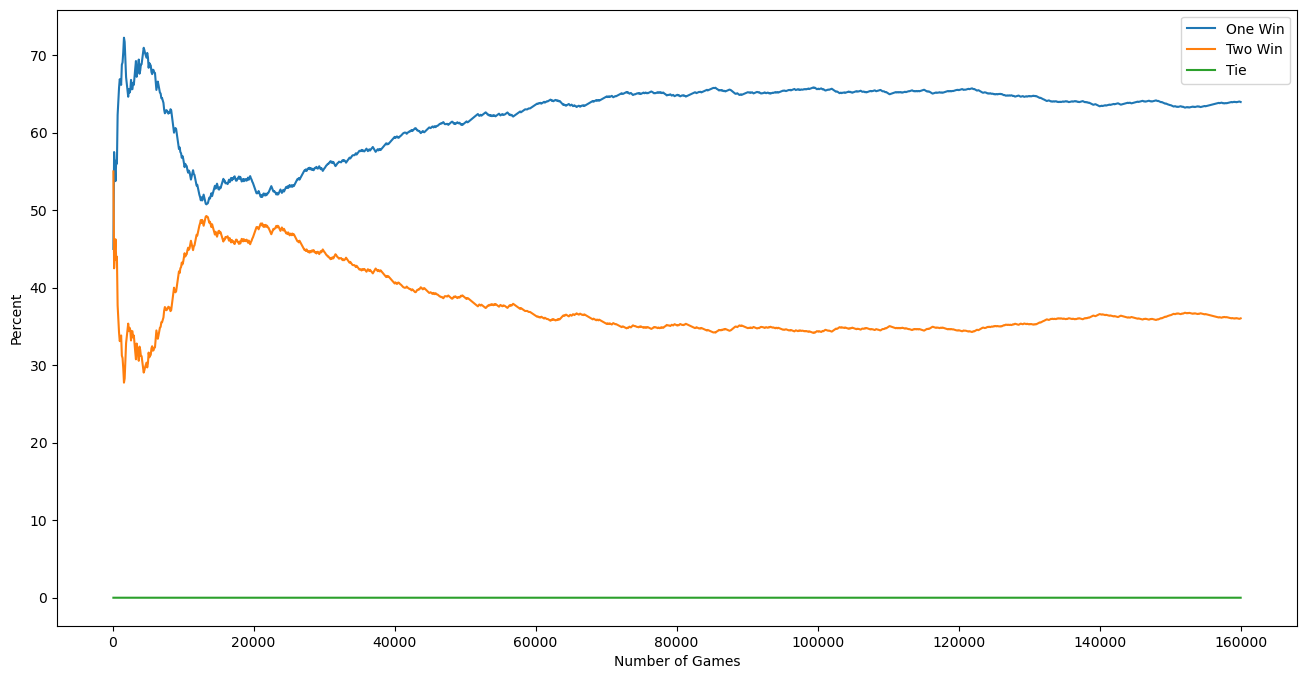

In [36]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

## Test

In [37]:
Q1_agent.learning=False
Q2_agent.learning=False

In [38]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(minimax_agent,minimax_agent)
g.report()


KeyboardInterrupt



In [ ]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(minimax_agent,Q2_agent)
g.report()

In [39]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(Q1_agent,random_agent)
g.report()

Total number of games:  1000
Winning 99.80 percent
Losing 0.20 percent
Tie 0.00 percent


In [40]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(random_agent,Q2_agent)
g.report()

Total number of games:  1000
Winning 0.20 percent
Losing 99.80 percent
Tie 0.00 percent


## Play a game or two against it to see how good it is

In [41]:
g=Game(number_of_games=1)

result=g.run(human_agent,Q2_agent)

====
Game  1
 1  2  1  2 
 0  0  0  0 
 0  0  0  0 
 2  1  2  1 

Player  1
 0  1  2  3 
 4  5  6  7 
 8  9 10 11 
12 13 14 15 

Your valid moves are:  [[0, 4], [2, 6], [13, 9], [15, 11]]


What is your move? (e.g. [2,6] [2,6]


Player 1 moves [2, 6]
 1  2  0  2 
 0  0  1  0 
 0  0  0  0 
 2  1  2  1 

Player 2 moves [3, 2]
 1  2  2  0 
 0  0  1  0 
 0  0  0  0 
 2  1  2  1 

Player  1
 0  1  2  3 
 4  5  6  7 
 8  9 10 11 
12 13 14 15 

Your valid moves are:  [[0, 4], [6, 10], [6, 7], [6, 5], [13, 9], [15, 11]]


What is your move? (e.g. [2,6] [6,5]


Player 1 moves [6, 5]
 1  2  2  0 
 0  1  0  0 
 0  0  0  0 
 2  1  2  1 

Player 2 moves [14, 10]
 1  2  2  0 
 0  1  0  0 
 0  0  2  0 
 2  1  0  1 

Player  1
 0  1  2  3 
 4  5  6  7 
 8  9 10 11 
12 13 14 15 

Your valid moves are:  [[0, 4], [5, 9], [5, 6], [5, 4], [13, 9], [13, 14], [15, 11], [15, 14]]


What is your move? (e.g. [2,6] [15,14]


Player 1 moves [15, 14]
 1  2  2  0 
 0  1  0  0 
 0  0  2  0 
 2  1  1  0 

Player 2 moves [2, 6]
 1  2  0  0 
 0  1  2  0 
 0  0  2  0 
 2  1  1  0 

Player  1
 0  1  2  3 
 4  5  6  7 
 8  9 10 11 
12 13 14 15 

Your valid moves are:  [[0, 4], [5, 9], [5, 4], [13, 9], [14, 15]]


What is your move? (e.g. [2,6] [13,9]


Player 1 moves [13, 9]
 1  2  0  0 
 0  1  2  0 
 0  1  2  0 
 2  0  1  0 

Player 2 moves [10, 11]
 1  2  0  0 
 0  1  2  0 
 0  1  0  2 
 2  0  1  0 

Player  2 won.


In [42]:
SaveTable(Q1_agent.Q,'4x4 Sliding TTT - Q1 Table.json')

In [43]:
SaveTable(Q2_agent.Q,'4x4 Sliding TTT - Q2 Table.json.zip')